In [1]:
import requests
import pandas as pd
import json
import numpy
from pycoingecko import CoinGeckoAPI
from datetime import datetime
pd_v = pd.__version__
python_v = !python -V
gecko_v = !pip show pycoingecko
print("version", *python_v)
print("version Pandas", pd_v)
print("version Requests", requests.__version__)
print("pycoingecko", gecko_v[1])
# dir(CoinGeckoAPI)

version Python 3.10.5
version Pandas 2.0.2
version Requests 2.26.0
pycoingecko Version: 2.2.0


**Входные данные**

In [2]:
### First API
url_1 = 'https://api.wazirx.com/sapi/v1/tickers/24hr'

In [3]:
### Second API
url_2 = 'https://api2.binance.com/api/v3/ticker/24hr'

In [4]:
### Third API
cg = CoinGeckoAPI()

**Решение (Эскиз)**

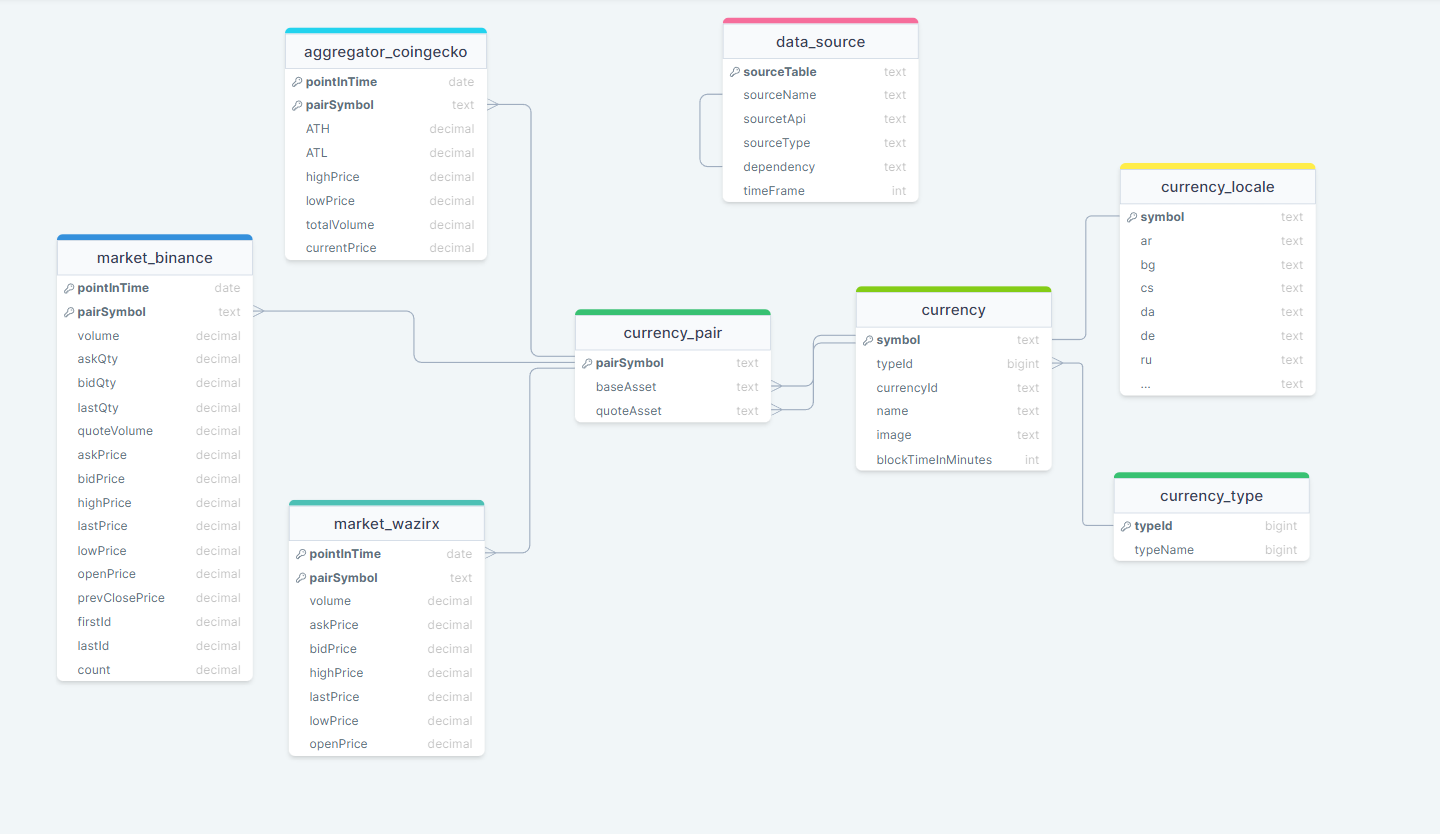

Некоторые параметры являются расчетными и их можно не добавлять в таблицу данных,
а использовать функции для их расчета при необходимости, например:
    
priceChange = lastPrice – openPrice

priceChangePercent = (lastPrice - openPrice / openPrice) * 100

In [16]:
# Таблица источников данных
df_market = pd.DataFrame({'sourceTable': ['aggregator_coingecko', 'market_binance', 'market_wazirx'],
                          'sourceName': ['CoinGecko', 'Binance', 'Wazirx'],
                         'api': ['CoinGeckoAPI()',  url_2, url_1,],
                          'sourceType': ['data aggregator', 'market', 'market'],
                          'dependency': [None, None, 'Binance'],
                          'timeFrame': [['24hr', '1hr', '...'], '24hr', '24hr']
                         })
df_market

,sourceTable,sourceName,api,sourceType,dependency,timeFrame
0,aggregator_coingecko,CoinGecko,CoinGeckoAPI(),data aggregator,None,"[24hr, 1hr, ...]"
1,market_binance,Binance,https://api2.binance.com/api/v3/ticker/24hr,market,None,24hr
2,market_wazirx,Wazirx,https://api.wazirx.com/sapi/v1/tickers/24hr,market,Binance,24hr


In [37]:
response_1 = requests.get(url_1)
print("wazirx:", response_1.status_code)

wazirx: 200


In [21]:
# Биржа wazirx (пример)
pd.set_option("display.float_format", "{:.5f}".format)
df_wazirx = pd.read_json(response_1.text)
df_wazirx['at'] = df_wazirx['at'].apply(lambda x: \
    datetime.utcfromtimestamp(x / 1000).strftime('%Y-%m-%d %H:%M:%S'))
df_wazirx.rename(columns={'at': 'pointInTime'}, inplace=True)
df_wazirx.drop(['baseAsset', 'quoteAsset'], axis=1, inplace=True)
df_wazirx
df_wazirx.head()

,symbol,openPrice,lowPrice,highPrice,lastPrice,volume,bidPrice,askPrice,pointInTime
0,btcinr,2637959.00000,2601111.00000,2651378.00000,2645000.00000,6.67022,2645000.00000,2646065.00000,2023-07-03 06:39:18
1,xrpinr,41.41120,40.70810,42.69920,40.70810,154124.90000,40.80010,41.51000,2023-07-03 06:39:18
2,ethinr,164192.90000,162700.00000,168000.00000,167633.00000,56.60390,167633.00000,167633.60000,2023-07-03 06:39:18
3,trxinr,6.52680,6.45010,6.62000,6.58000,540750.00000,6.58000,6.62000,2023-07-03 06:39:18
4,eosinr,66.28000,66.28000,72.35000,69.40000,122.24000,69.40000,71.59000,2023-07-03 06:39:18


In [83]:
response_2 = requests.get(url_2)
print("binance:", response_2.status_code)

binance: 200


In [35]:
# Биржа binance (пример)
pd.set_option('display.max_columns', 25)
pd.set_option("display.float_format", "{:.5f}".format)
df_binance = pd.read_json(response_2.text)
df_binance.drop(['priceChange', 'priceChangePercent', 'weightedAvgPrice', 'openTime'], axis=1, inplace=True)
df_binance['closeTime'] = df_binance['closeTime'].apply(lambda x: \
     datetime.utcfromtimestamp(x / 1000).strftime('%Y-%m-%d %H:%M:%S'))
df_binance['symbol'] = df_binance['symbol'].apply(lambda x: x.lower())
df_binance.rename(columns={'closeTime': 'pointInTime'}, inplace=True)
df_binance.head()

,symbol,prevClosePrice,lastPrice,lastQty,bidPrice,bidQty,askPrice,askQty,openPrice,highPrice,lowPrice,volume,quoteVolume,pointInTime,firstId,lastId,count
0,ethbtc,0.06278,0.06367,0.06280,0.06367,129.42180,0.06368,33.80570,0.06278,0.06375,0.06256,25401.83930,1603.27737,2023-07-03 07:21:15,420520236,420567930,47695
1,ltcbtc,0.00363,0.00366,6.59900,0.00365,2.35400,0.00366,30.78800,0.00363,0.00380,0.00357,212088.68500,775.98991,2023-07-03 07:21:13,92172116,92238821,66706
2,bnbbtc,0.00804,0.00807,0.15000,0.00807,4.15900,0.00807,11.69200,0.00804,0.00809,0.00798,38825.80100,312.10955,2023-07-03 07:21:17,224427971,224464514,36544
3,neobtc,0.00031,0.00031,90.22000,0.00031,116.86000,0.00031,29.44000,0.00031,0.00032,0.00031,196950.24000,61.68851,2023-07-03 07:21:14,45272108,45279187,7080
4,qtumeth,0.00149,0.00142,4.20000,0.00142,71.80000,0.00143,9.40000,0.00149,0.00152,0.00142,7891.90000,11.59917,2023-07-03 07:20:11,5394546,5394761,216


In [38]:
# Сущность currency (пример)
all_coins_list = cg.get_coins_list()
currency = []
stop = 10 # Больше запросов в минуту не дает сделать бесплатно, а через sleep слишком долго ждать, для примера достаточно
for i in all_coins_list:
    tmp = cg.get_coin_by_id(i['id'])
    currency.append({'symbol': tmp['symbol'],
                    'currencyId': tmp['id'],
                    'name': tmp['name'],
                    'image': tmp['image']['small'],
                    'block_time_in_minutes': tmp['block_time_in_minutes']})
    stop -= 1
    if stop == 0:
        break
df_currency = pd.DataFrame(currency)
df_currency

,symbol,currencyId,name,image,block_time_in_minutes
0,zoc,01coin,01coin,https://assets.coingecko.com/coins/images/5720...,0
1,zcn,0chain,Zus,https://assets.coingecko.com/coins/images/4934...,0
2,vix,0vix-protocol,0VIX Protocol,https://assets.coingecko.com/coins/images/2908...,0
3,zrx,0x,0x Protocol,https://assets.coingecko.com/coins/images/863/...,0
4,0x0,0x0-ai-ai-smart-contract,0x0.ai: AI Smart Contract,https://assets.coingecko.com/coins/images/2888...,0
5,0xa,0xauto-io-contract-auto-deployer,0xAuto.io : Contract Auto Deployer,https://assets.coingecko.com/coins/images/3067...,0
6,oxd,0xdao,0xDAO,https://assets.coingecko.com/coins/images/2288...,0
7,oxd v2,0xdao-v2,0xDAO V2,https://assets.coingecko.com/coins/images/2446...,0
8,0xmr,0xmonero,0xMonero,https://assets.coingecko.com/coins/images/1103...,10
9,shield,0xshield,0xShield,https://assets.coingecko.com/coins/images/3035...,0


In [68]:
# Сущность currency_pair (пример)
# quote = set(df_currency['symbol']) 
# В df_currency сохранены не все, поэтому для примера беру самые популярные валюты
quote_sample = {'btc', 'usd', 'usdt', 'bnb', 'eth', 'inr', 'wrx'} 


def find_base_and_quote(row):
    sub_s = row['symbol']
    i = len(sub_s)
    while sub_s[i:] not in quote_sample and i > 2: 
        i -= 1
    if i > 2:
        row.baseAsset = sub_s[:i]
        row.quoteAsset = sub_s[i:]
    return row


df_pair = pd.DataFrame(pd.concat([df_binance['symbol'], df_wazirx['symbol']]))
df_pair.drop_duplicates(inplace=True)
df_pair['baseAsset'] = 0
df_pair['quoteAsset'] = 0
df_pair = df_pair.apply(find_base_and_quote, axis='columns')
df_pair


,symbol,baseAsset,quoteAsset
0,ethbtc,eth,btc
1,ltcbtc,ltc,btc
2,bnbbtc,bnb,btc
3,neobtc,neo,btc
4,qtumeth,qtum,eth
...,...,...,...
450,1inchwrx,1inch,wrx
451,dockwrx,dock,wrx
452,runewrx,rune,wrx
453,chrwrx,chr,wrx


In [82]:
# Сущность coinGecko (пример)
example = cg.get_coin_by_id('bitcoin') 
pd.set_option('display.max_columns', 42)
df_gecko = pd.DataFrame(example['market_data'])
df_gecko.reset_index(inplace=True)
df_gecko['index'] = df_gecko['index'].map(lambda x: 'btc' + x)
df_gecko.rename(columns={'index': 'symbol'}, inplace=True)
df_gecko.head()

,symbol,current_price,total_value_locked,mcap_to_tvl_ratio,fdv_to_tvl_ratio,roi,ath,ath_change_percentage,ath_date,atl,atl_change_percentage,atl_date,market_cap,market_cap_rank,fully_diluted_valuation,total_volume,high_24h,low_24h,price_change_24h,price_change_percentage_24h,price_change_percentage_7d,...,price_change_percentage_30d,price_change_percentage_60d,price_change_percentage_200d,price_change_percentage_1y,market_cap_change_24h,market_cap_change_percentage_24h,price_change_24h_in_currency,price_change_percentage_1h_in_currency,price_change_percentage_24h_in_currency,price_change_percentage_7d_in_currency,price_change_percentage_14d_in_currency,price_change_percentage_30d_in_currency,price_change_percentage_60d_in_currency,price_change_percentage_200d_in_currency,price_change_percentage_1y_in_currency,market_cap_change_24h_in_currency,market_cap_change_percentage_24h_in_currency,total_supply,max_supply,circulating_supply,last_updated
0,btcaed,112550.00000,None,None,None,None,253608.00000,-55.61544,2021-11-10T14:24:11.849Z,632.31000,17701.74866,2015-01-14T00:00:00.000Z,2185822679017,1,2363822083953,40453310608,113080.00000,111877.00000,119.85900,0.39269,0.79187,...,12.74356,5.37945,73.14049,59.90284,2437344241,0.41125,438.41000,-0.27339,0.39105,0.79022,15.95238,12.74555,5.39853,73.15133,59.90153,8916719658.00000,0.40961,21000000.00000,21000000.00000,19418668.00000,2023-07-03T08:41:01.238Z
1,btcars,7866829.00000,None,None,None,None,8004156.00000,-1.70502,2023-06-30T04:55:27.242Z,1478.98000,531867.85551,2015-01-14T00:00:00.000Z,152779927734290,1,165221346923490,2827544845597,7889962.00000,7779422.00000,119.85900,0.39269,0.79187,...,12.74356,5.37945,73.14049,59.90284,2437344241,0.41125,37661.00000,-0.26624,0.48103,2.78121,19.42297,20.39595,20.15003,158.33717,227.08448,758087278742.00000,0.49867,21000000.00000,21000000.00000,19418668.00000,2023-07-03T08:41:01.238Z
2,btcaud,46045.00000,None,None,None,None,93482.00000,-50.73369,2021-11-10T14:24:11.849Z,72.61000,63328.83729,2013-07-05T00:00:00.000Z,894332545016,1,967161261799,16549879112,46320.00000,45687.00000,119.85900,0.39269,0.79187,...,12.74356,5.37945,73.14049,59.90284,2437344241,0.41125,235.02000,-0.38593,0.51302,1.16140,19.66444,12.16870,5.66382,77.27262,63.77083,4817959870.00000,0.54164,21000000.00000,21000000.00000,19418668.00000,2023-07-03T08:41:01.238Z
3,btcbch,104.21700,None,None,None,None,270.67700,-61.47878,2023-06-10T04:30:21.139Z,3.51389,2867.31315,2017-08-02T00:00:00.000Z,2024747716,1,2189630207,37458266,105.69000,100.23400,119.85900,0.39269,0.79187,...,12.74356,5.37945,73.14049,59.90284,2437344241,0.41125,-1.47267,0.58465,-1.39339,-33.66742,-57.83712,-55.98120,-57.48801,-35.82797,-43.56882,-25985428.87193,-1.26713,21000000.00000,21000000.00000,19418668.00000,2023-07-03T08:41:01.238Z
4,btcbdt,3300322.00000,None,None,None,None,5922005.00000,-44.26363,2021-11-10T14:24:11.849Z,9390.25000,35050.38599,2013-09-08T00:00:00.000Z,64095405866857,1,69314925369959,1186222188549,3315840.00000,3273896.00000,119.85900,0.39269,0.79187,...,12.74356,5.37945,73.14049,59.90284,2437344241,0.41125,-1827.50926,-0.27257,-0.05534,0.66208,15.27928,13.17256,6.97664,80.80402,84.29090,-23637818874.91406,-0.03687,21000000.00000,21000000.00000,19418668.00000,2023-07-03T08:41:01.238Z
